<a href="https://colab.research.google.com/github/suchy1713/EmotionPredicition/blob/master/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

df = pd.read_csv('https://raw.githubusercontent.com/suchy1713/EmotionPredicition/master/data/preprocessed/data.csv')
data = df.values
X = data[:, :11]
y = data[:, 11:].argmax(axis=1)

We are going to evaluate our models using cross validation. We considered using just training and test sets but it turned out that the dataset is not too big and CV is not taking too long. We will also measure learning time as it might help us with final choice of the best model.

For hyperparameter tuning we decided to go with grid search to automatize this process just a little bit.

In [0]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score
import time
import seaborn as sns
import matplotlib.pyplot as plt

def get_performance(model, X, y):
    start = time.time()
    score = np.mean(cross_val_score(model, X, y, cv=5))
    end = time.time()

    return score, end-start

def find_best_params(model, X, y, params):
    grid = GridSearchCV(estimator=model, param_grid=params, verbose=10, n_jobs=-1)
    grid.fit(X, y)

    print('\n\nACCURACY: ', grid.best_score_)
    print('BEST PARAMS:', grid.best_params_)

def plot_model_comparison(accuracies, times, legend):
    plt.figure(figsize=(8,6))
    sns.scatterplot(x=accuracies, y=times, hue=legend, s=150)

    plt.title('Model performance comparison')
    plt.xlabel('Accuracy')
    plt.ylabel('Time')

For our first pass, we chose the widest range of models we could possibly think of:<br>
-> Logistic Regression<br>
-> Naive Bayes (probability based)<br>
-> Support Vector Classifier (distance based)<br>
-> Decision Tree<br>
-> Random Forest (tree ensemble)<br>
-> XG Boost (tree ensemble)<br>
-> Neural Network<br>

In [0]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.neural_network import MLPClassifier

Let's compare their default versions. This step should let us eliminate the ones that definitely are not going to perform well on this type of data.

Logistic Regression  - Accuracy:  0.3925627240143369  Time:  2.585238218307495
Naive Bayes  - Accuracy:  0.3492831541218638  Time:  0.0481564998626709
Support Vector Machine  - Accuracy:  0.39874551971326166  Time:  27.475837230682373
Decision Tree  - Accuracy:  0.4198028673835125  Time:  0.08410239219665527
Random Forest  - Accuracy:  0.42034050179211474  Time:  3.1563358306884766
XG Boost  - Accuracy:  0.4141577060931899  Time:  7.393480539321899
Neural Network  - Accuracy:  0.4145161290322581  Time:  67.76044654846191


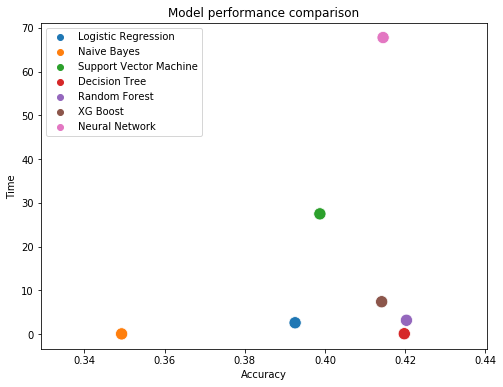

In [0]:
legend = ['Logistic Regression', 'Naive Bayes', 'Support Vector Machine', 'Decision Tree', 'Random Forest', 'XG Boost', 'Neural Network']
models = [LogisticRegression(), GaussianNB(), SVC(), DecisionTreeClassifier(), RandomForestClassifier(), xgb.XGBClassifier(), MLPClassifier(max_iter=1000)]
times = []
accuracies = []

for model, name in zip(models, legend):
    a, t = get_performance(model, X, y)
    accuracies.append(a)
    times.append(t)
    print(name, ' - Accuracy: ', a, ' Time: ', t)

plot_model_comparison(accuracies, times, legend)

At this point we can rule out the Naive Bayes Classifier. Despite its great learning speed, it will never be able to compete with other models in terms of accuracy.

Now onto hyperparameter tuning:

Logistic Regression:<br>
C - inverse of regularization strength (smaller values specify stronger regularization)

In [19]:
brain = LogisticRegression()
c = np.array([0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000])
params = dict(C = c)

find_best_params(brain, X, y, params)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1250s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Batch computation too slow (2.0160s.) Setting batch_size=1.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    8.4s finished




ACCURACY:  0.392831541218638
BEST PARAMS: {'C': 10.0}


Support Vector Classifier:
